In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# We opt to define all the global configuration settings through this dict
config = {"resampling_fs" : 22050, #expected resampling rate on HDF5 file creation
          "dst_path":"./choral_dst", # User Dataset path (if None, the default one will be used)
          "hdf5_filepath":"./choral_dst.hdf5",
          "batch_size_train": 1024,
          "batch_size_test": 512,
          "num_frames": 132300
         }

if not os.path.isdir('./debug'):
    os.mkdir('./debug')

<h1><center>Data Handling Methodology</center></h1>

For the first step of this task, we will work from the __Choral Singing Dataset__, which contains three choir songs composed of 4 groups of 4 singers (16 parts per song), for a total of 48 stems. The dataset can be downloaded from Zenodo at the following:

https://zenodo.org/record/2649950#.XlJRNy2ZPRY

If you happen to already have the dataset locally, please define it's local path through the ***dst_path*** variable. Otherwise, the cell below will take care of downloading it for you:
***
### 1. Dataset Download:

In [22]:
#This cell downloads the Mridangam Stroke Dataset in its entirety
import urllib.request
import zipfile
import os, sys,shutil

#Link for the dataset. If you already have the dataset locally, define its location through the config dict above 
url = 'https://zenodo.org/record/2649950/files/ChoralSingingDataset.zip'

if config["dst_path"] == None:
    main_data_dir = './choral_dst'
    if not os.path.exists(main_data_dir): #creating the directory if not exist
        os.mkdir(main_data_dir)
    print('Downloading Choral Singing Dataset Dataset...')
    foldername = url.split('/')[-1]
    urllib.request.urlretrieve(url,foldername)
    #Unzipping to a specific folder
    zip_ref = zipfile.ZipFile(foldername, 'r')
    zip_ref.extractall(main_data_dir)
    zip_ref.close()
    os.remove(foldername)#Removing the zip file
    print('Data downloaded and unzipped to: ',main_data_dir)
else:
    print('User Path Defined. Dataset Expected to be Found at the Following:\n'+config["dst_path"])
 

User Path Defined. Dataset Expected to be Found at the Following:
./choral_dst


***
### 2. Storing our Data in a Convenient Format

For the sake of simplicity and clarity, we will store our song stems in a **HDF5 file**, which will help us to manage the later steps a bit more easily. This hierarchical file format will allow us to store our data in an intuitive way as follow:

**[HDF5_File] -> [Set] -> [Song] -> [Part]**

Since our dataset is of *very* limited size, we will break it down as follow:

| Set   | Stems | Songs |
| :---:   | :---: | :---: |
| Train |    24   |    A, B   |
| Valid |   8    |   A, B    |
| Test  |16| C |

**Note:** By default, the Choral Singing Dataset follow the following naming convention:

*DatasetName_SongAcronym_PartName_PartNumber.wav*

In [23]:
import h5py
import librosa
import soundfile
import glob
import random
from tqdm import tqdm
from time import sleep
from pathlib import Path

# First check if HDF5 already exists:
hdf5_file = Path(config['hdf5_filepath'])
if not hdf5_file.is_file():
    tracks = dict()
    resampling_fs = config['resampling_fs']
    dst_path = './choral_dst' if (config['dst_path'] == None) else config['dst_path']

    # Get all the stem files
    dst_stems = glob.glob(dst_path+"/*.wav",recursive=False)
    # Extract only songs from name
    songs = set([os.path.splitext(os.path.basename(i))[0].split('_')[1] for i in dst_stems])
    # Take 2/3 of songs for train/valid
    train_val_songs = random.sample(songs, int(np.ceil(0.666*len(songs))))
    # Take the rest as test set
    test_song = list(set(songs) - set(train_val_songs))
    test_idx = [int(i) for i, track in enumerate(dst_stems) if [True for song in test_song if str('_'+song+'_') in track]]
    # Take one random group of singer per song for each song as validation set
    rand_part = random.randint(1,4)
    val_idx   = [int(i) for i, track in enumerate(dst_stems) if [True for song in train_val_songs if ((str('_'+song+'_') in track) and (str('_'+str(rand_part)+'.wav')) in track)]]
    # Deduce the train set from valid / test set
    train_idx = list(set(range(len(dst_stems))) -  (set(val_idx + test_idx)))

    # tracks['train'] = np.take(dst_stems, train_idx)
    tracks['train'] = np.take(dst_stems, train_idx)
    tracks['valid'] = np.take(dst_stems, val_idx)
    tracks['test'] = np.take(dst_stems, test_idx)

    print('Ready to create HDF5')

    h5file = h5py.File(config["hdf5_filepath"], "w")

    # Write stems to hdf5 file for train/valid/test partitions
    for curr_partition in ["train", "valid", "test"]:

        print("Writing " + curr_partition + " partition with "+str(len(tracks[curr_partition]))+" files...")

        stem_list = tracks[curr_partition]

        # Create group for set if needed
        if not str(curr_partition) in h5file:
            set_grp  = h5file.create_group(curr_partition)

        sleep(1)

        for track in tqdm(stem_list):

            filename = os.path.splitext(os.path.basename(track))[0].split('_')

            song = filename[1]
            part = ''.join(filename[2:4])

            # Create group for the Song if needed
            if not str(curr_partition+'/'+song) in h5file:
                song_grp  = set_grp.create_group(song)

            # Create group for the Part if needed
            if not str(curr_partition+'/'+song+'/'+part) in h5file:
                part_grp = h5file[str(curr_partition+'/'+song)]
                subgrp  = part_grp.create_group(part)

            # Once part groups / song subgroups are created, store file
            audio, s = librosa.load(track, sr=resampling_fs)
            subgrp = h5file[str(curr_partition+'/'+song+'/'+part)]
            subgrp.create_dataset("raw_wav",data=audio)

    print('Done Creating HDF5 at path: '+config['hdf5_filepath'])
    h5file.close()
else:
    print('HDF5 Already Exists. File Expected to be Found at the Following:\n'+config["hdf5_filepath"])

HDF5 Already Exists. File Expected to be Found at the Following:
./choral_dst.hdf5


***
### 3. Defining the Generator Function:

Instead of computing features on the entirety of each of these songs, we will create many song snippets (or frames), which will depict different possible musical settings (SAT, ATB, SB, etc.) out of the songs. This will allow us to cover all possible singer permutations on a per-frame basis, without having to compute and feed to the model substantial chunk of audio.

The next step would be to define the function that will generate these song frames for us. 

**Note:** This function will yield the song segments but won't render them to disk. We can proceed by computing everything on the fly and save ourselves some local memory space.

In [24]:
def batchGenerator(hdf5_filepath, batch_size, num_frames, partition='train', debug=False):
    
    dataset   = h5py.File(hdf5_filepath, "r")
    itCounter = 0

    itCounter = itCounter + 1
    
    # Choose random song and retrieve all available part for it
    randsong = random.choice(list(dataset[partition].keys())) # Get random song from dataset keys
    sources  = list(dataset[partition][randsong].keys())      # Get all available sources for song
    
    # Compute available parts per group
    part_per_group = dict({'soprano':None,'alto':None,'tenor':None,'bass':None})
    for group in part_per_group.keys():
        parts = [source[-1] for source in sources if group in source]
        part_per_group[group] = parts

    # Init the start/end values of song snippet
    startspl = 0
    endspl   = 0

    # Preping the output shape of the generator
    out_shapes = {'mix':np.zeros((batch_size, num_frames)),'num_sing':np.zeros((batch_size),dtype=int)}

    # Will create batch_size x mixes of unique singers permutations
    for i in range(batch_size):

        randsources = random.sample(part_per_group.keys(), random.randint(1,4)) # Randomize source pick

        # Get Start and End samples. Pick random part to calculate start/end spl
        randpart = random.choice(sources)
        startspl = random.randint(0,len(dataset[partition][randsong][randpart]['raw_wav'])-num_frames) # This assume that all stems are the same length
        endspl   = startspl+num_frames

        # Get Random Sources with part number: 
        randsources_with_part = ["{}{}".format(a, random.choice(part_per_group[a])) for a in randsources] # Concatenate strings for part name
        # Retrieve the chunks and store them in output shapes                                         
        for source in randsources_with_part:

            source_chunk = dataset[partition][randsong][source]['raw_wav'][startspl:endspl]              # Retrieve part's chunk
            out_shapes['mix'][i] = np.add(out_shapes['mix'][i],source_chunk)            # Add the chunk to the mix

        # Scale down the mix based off number of sources
        scaler = len(randsources_with_part)
        out_shapes['mix'][i] = (out_shapes['mix'][i]/scaler)
        out_shapes['num_sing'][i] = len(randsources_with_part)

    # if debug == True, pick one random mix from batch and synthesize it
    if debug==True:

        rand_pick = random.randint(0,batch_size-1)
        debug_dir = './debug/it#'+str(itCounter)+'_batchpick#'+str(rand_pick)
        if not os.path.isdir(debug_dir):
            os.mkdir(debug_dir)
        soundfile.write(debug_dir+'/'+'mix_'+str(out_shapes['num_sing'][rand_pick])+'_singers_'+'.wav', out_shapes['mix'][rand_pick], config['resampling_fs'], 'PCM_24')
            
    
    return (out_shapes['mix'], out_shapes['num_sing'])

As you can see, the generator function returns a dictionary of shape:<br>
```out_shapes = {'mix':np.zeros((batch_size, num_frames)),'num_sing':np.zeros((batch_size))}``` <br><br>where:
* the key ```'mix'``` holds ```<batch_size>``` number of snippet of size ```<num_frames>```
* the key ```'num_sing'``` holds the ground truth respective to each of these mixes

<br>The purpose of the generator function is to strictly provide the time-domain snippets. For the pre-processing steps related to frequency-domain conversion and more, see the next section below:

***
<h1><center>Features Extraction Step</center></h1>

The first step of our experiment entails training a deep neural network model using some low-level spectral features extracted using the audio analysis library **Essentia**. 

***
### 1. Computing Time-Domain Snippets

In [25]:
num_frames = config['num_frames'] # size of song snippets

audio_data_train, y_train = batchGenerator(config['hdf5_filepath'], config['batch_size_train'], num_frames, partition='train', debug=True)
print('Audio Data for Training Loaded with Shape:\n'+ str(np.shape(audio_data_train)))
print('Ground Truth for Training Loaded with Shape:\n'+ str(np.shape(y_train)))
audio_data_test, y_test = batchGenerator(config['hdf5_filepath'], config['batch_size_test'], num_frames, partition='test', debug=True)
print('Audio Data for Testing Loaded with Shape:\n'+ str(np.shape(audio_data_test)))
print('Ground Truth for Testing Loaded with Shape:\n'+ str(np.shape(y_test)))

Audio Data for Training Loaded with Shape:
(1024, 132300)
Ground Truth for Training Loaded with Shape:
(1024,)
Audio Data for Testing Loaded with Shape:
(512, 132300)
Ground Truth for Testing Loaded with Shape:
(512,)


Now our audio data are loaded into a 2D numpy array called ```audio_data``` and our ground truth is loaded onto a 1D numpy array called ```y```. <br>

For what it is worth, let's plot a few audio snippets labeled with their respective ground truth:

<Figure size 720x7200 with 0 Axes>

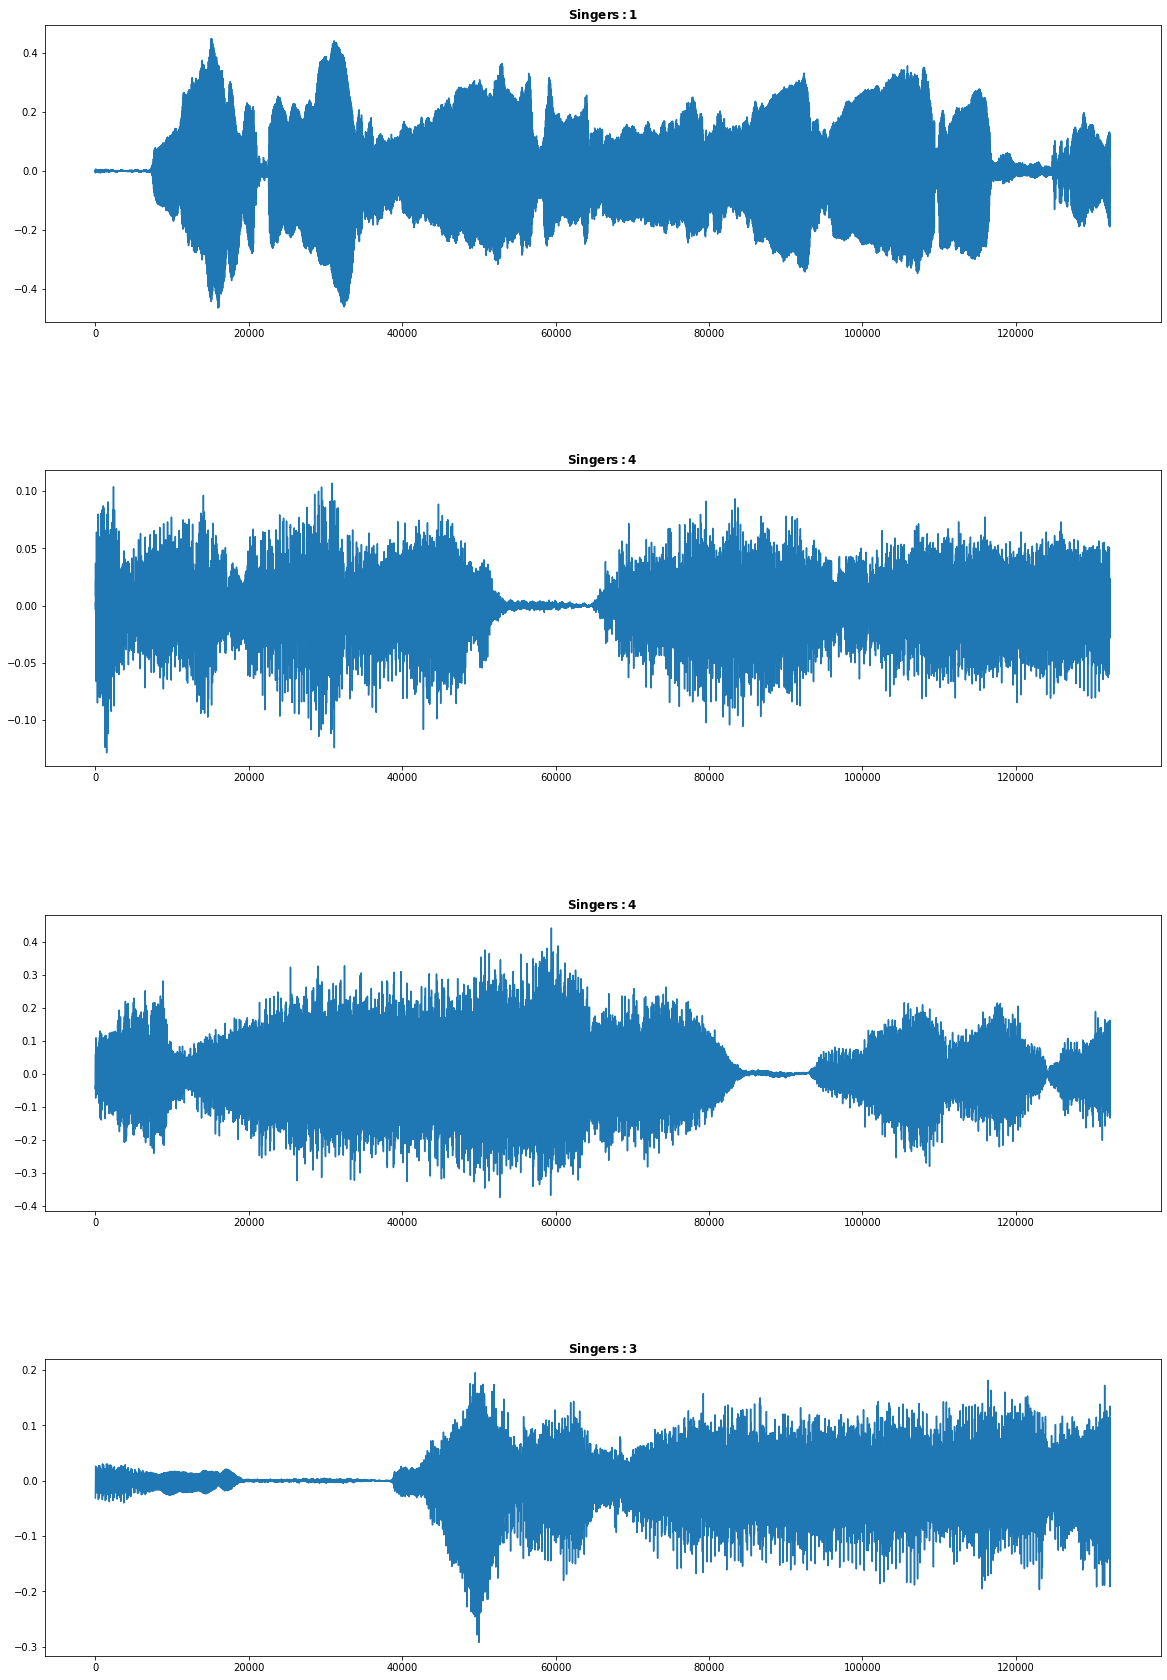

In [26]:
plt.figure(1, figsize=(10,100))
plt.subplots(4,1,figsize=(20,30))
plt.subplots_adjust(hspace=0.5)

for i in range(4):
    
    rand_snippet = random.randint(0,np.shape(audio_data_train)[0]-1) # Pick random snippet from audio_data
    x = audio_data_train[rand_snippet]
    num_singer = y_train[rand_snippet]

    plt.subplot(4, 1, (i+1))
    plt.plot(x)
    plt.title(r"$\bf{""Singers: "+str(num_singer)+ "}$")

***
### 2. Feature Extraction

Now is the time to actually extract the features from all the audio snippets we've just computed. We will exploit the fact that each singer in a SATB recording settings each have their respective singing range (that is to say, there is still a fair amount of harmonic overlap). <br>A first naive approach, would be to compute the __MFCC coefficients__ in the hope that this feature would accurately depict the recordings' frequency range in respect to the number of singers singing. Moreover, this feature seems like a good fit for our task as the signals we are dealing with only entail singing voice.

In [27]:
from essentia.standard import *

def createDataForPartition(audio):
    
    w = Windowing(type = 'hann')
    spectrum = Spectrum(size=4096)
    mfcc = MFCC(numberCoefficients=13,numberBands=128,inputSize=4096)
    logNorm = UnaryOperator(type='log')

    mfccs = np.empty([np.shape(audio)[0],int((config['num_frames']/2048)),13])
    melbands_log = np.empty([np.shape(audio)[0],int((config['num_frames']/2048)),128])

    sleep(1.0)

    # Compute MFCCS for all snippets: shape <snippet, coefficients>
    total_features = []
    for idx in tqdm(range(np.shape(audio)[0])):
        
        x = audio[idx]
        
        mfccs_tmp = []
        mel_bands_tmp = []
        spc_frame = []
        for frame in FrameGenerator(essentia.array(x), frameSize=4096, hopSize=2048, startFromZero=True):
            mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
            mfccs_tmp.append(mfcc_coeffs)
            mel_bands_tmp.append(logNorm(mfcc_bands))

        #Calculate average of MFCCs for all frame and store
        mfccs[idx,:,:] = mfccs_tmp
        melbands_log[idx,:,:] = mel_bands_tmp
        
    return melbands_log

Once we compute MFCCs for all audio snippet, let's plot some of them to make sure they look as expected:

Computing MFCCS for training set:


100%|██████████| 1024/1024 [00:05<00:00, 201.89it/s]


Computing MFCCS for test set:


100%|██████████| 512/512 [00:02<00:00, 203.72it/s]


<Figure size 7200x7200 with 0 Axes>

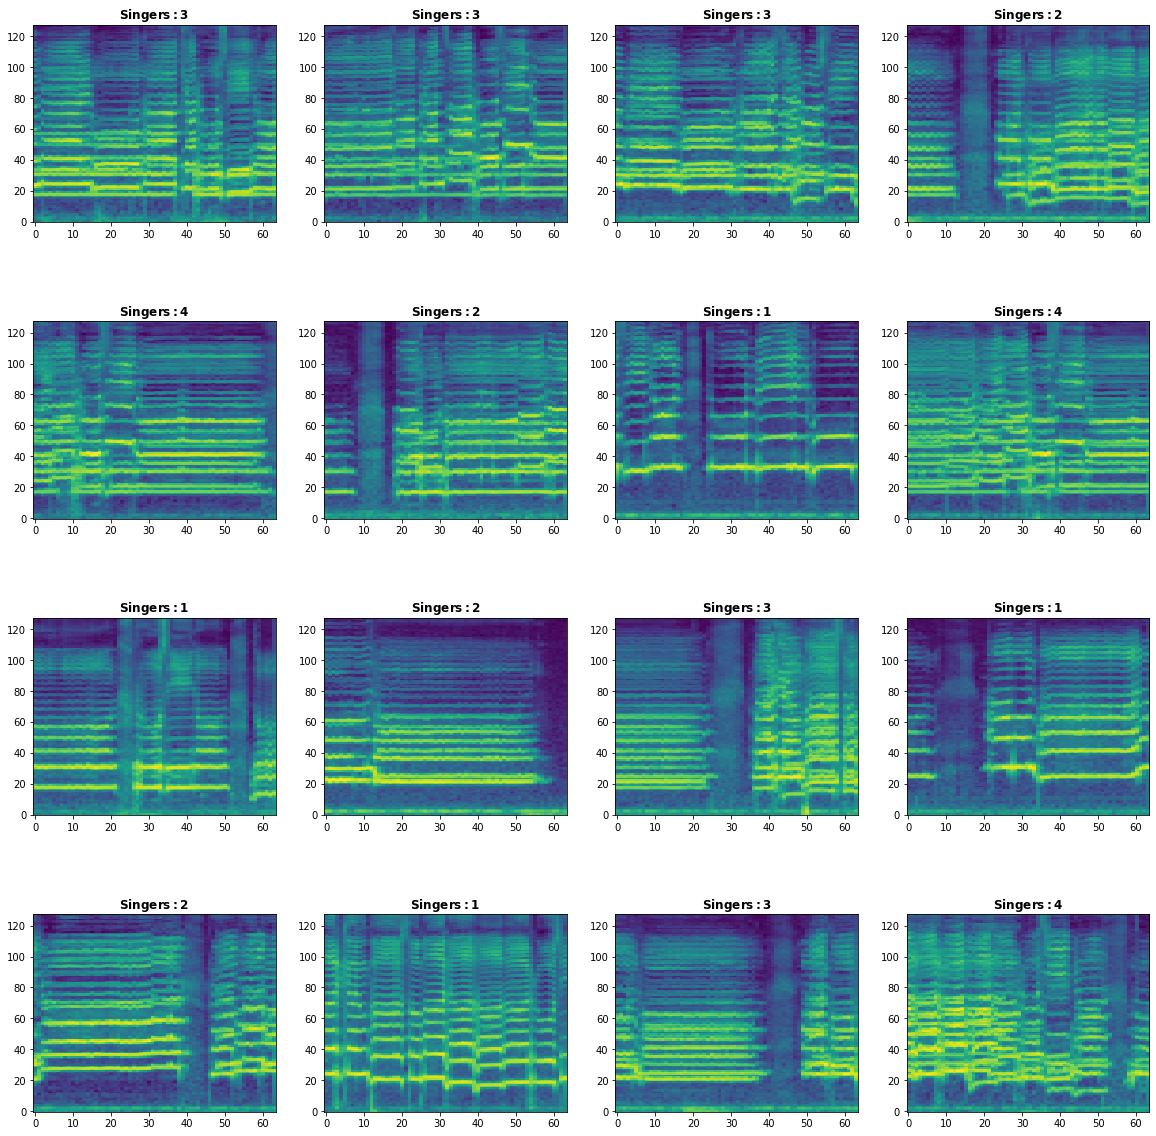

In [28]:
print('Computing MFCCS for training set:')
X_train = createDataForPartition(audio_data_train)
print('Computing MFCCS for test set:')
X_test  = createDataForPartition(audio_data_test)

plt.figure(1, figsize=(100,100))
plt.subplots(4,4,figsize=(20,20))
plt.subplots_adjust(hspace=0.5)

for i in range(16):
    
    rand_snippet = random.randint(0,np.shape(X_train)[0]-1) # Pick random snippet from audio_data
    mfcc = X_train[rand_snippet].T
    num_singer = int(y_train[rand_snippet])

    plt.subplot(4, 4, (i+1))
    plt.imshow(mfcc, aspect='auto', origin='lower', interpolation='none')
    plt.title(r"$\bf{""Singers: "+str(num_singer)+ "}$")

In [29]:
from sklearn.preprocessing import OneHotEncoder

# Then take mean of all frames
X_train_new = np.mean(np.asarray(X_train, dtype=np.float32),axis=1)
X_test_new = np.mean(np.asarray(X_test, dtype=np.float32),axis=1)

# Converting our y numerical values to one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))

# Finally, we end up with these shapes:
print('Audio Data for Training with Shape:\n'+ str(np.shape(X_train_new)))
print('Ground Truth for Training Loaded with Shape:\n'+ str(np.shape(y_train_onehot)))
print('Audio Data for Testing with Shape:\n'+ str(np.shape(X_test_new)))
print('Ground Truth for Testing Loaded with Shape:\n'+ str(np.shape(y_test_onehot)))


Audio Data for Training with Shape:
(1024, 128)
Ground Truth for Training Loaded with Shape:
(1024, 4)
Audio Data for Testing with Shape:
(512, 128)
Ground Truth for Testing Loaded with Shape:
(512, 4)


In [30]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 4))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_new.shape[1])

In [31]:
model.summary()
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_new, y_train_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0,)

score = model.evaluate(X_test_new, y_test_onehot, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (BatchNormalizati (None, 128)               512       
_________________________________________________________________
HiddenLayer_1 (Dense)        (None, 40)                5160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 40)                160       
_________________________________________________________________
activation_7 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 20)                820       
_________________________________________________________________
batch_normalization_6 (Batch (None, 20)               